In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
import seaborn as sns
sns.set_theme()

In [3]:
from typing import List
# https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot
# Tensorboard implementation for ema smoothing
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [4]:
data = pickle.load( open( "data_df.p", "rb" ) )

In [5]:
data.columns

Index(['idx', 'step', 'value', 'epoch', 'time', 'run.hash', 'run.bs',
       'run.epochs', 'run.eval_each_n_epochs_after_150_epochs',
       'run.eval_each_n_epochs', 'run.eval_mode', 'run.experiment',
       'run.freeze_encoder', 'run.img_size', 'run.load_checkpoint', 'run.loss',
       'run.lr', 'run.model_type', 'run.simulate_smaller_dataset',
       'metric.name', 'metric.context.gpu', 'metric.context'],
      dtype='object')

In [9]:
from collections import defaultdict

### Aggregate some run information into dicts

In [10]:
runs = {}
runs_info = defaultdict(dict)
for run_hash in data["run.hash"].unique():
    
    run_subset = data[data["run.hash"] == run_hash]
    
    runs[run_hash] = run_subset[run_subset["run.hash"] == run_hash]
    
    runs_info[run_hash]["simulate_smaller_dataset"] = run_subset.iloc[0]["run.simulate_smaller_dataset"]
    runs_info[run_hash]["model_type"] = run_subset.iloc[0]["run.model_type"]
    runs_info[run_hash]["load_checkpoint"] = run_subset.iloc[0]["run.load_checkpoint"]
    runs_info[run_hash]["freeze_encoder"] = run_subset.iloc[0]["run.freeze_encoder"]

In [11]:
small_runs = [run for run in runs.keys() if runs_info[run]["simulate_smaller_dataset"] == 0.1]
big_runs = [run for run in runs.keys() if runs_info[run]["simulate_smaller_dataset"] == 1.0]

In [12]:
point2runs = [run for run in runs.keys() if runs_info[run]["simulate_smaller_dataset"] == 0.2]
point5runs = [run for run in runs.keys() if runs_info[run]["simulate_smaller_dataset"] == 0.5]

### Raw Plot construction

In [36]:
set([runs_info[x]["load_checkpoint"] for x in runs.keys()])

{None,
 'maecheckpoints/mae_seq1_crop128_checkpoint-10.pth',
 'maecheckpoints/mae_seq1_crop128_checkpoint-20.pth',
 'maecheckpoints/mae_seq1_crop128_checkpoint-30.pth',
 'maecheckpoints/mae_seq1_crop128_checkpoint-40.pth',
 'maecheckpoints/mae_seq1_crop128_checkpoint-50.pth'}

In [54]:
color_mapping = {
    "maecheckpoints/mae_seq1_crop128_checkpoint-10.pth": "C0",
    "maecheckpoints/mae_seq1_crop128_checkpoint-20.pth": "C1",
    "maecheckpoints/mae_seq1_crop128_checkpoint-30.pth": "C2",
    "maecheckpoints/mae_seq1_crop128_checkpoint-40.pth": "C3",
    "maecheckpoints/mae_seq1_crop128_checkpoint-50.pth": "C5",
    None: "C5"
}

Text(0, 0.5, 'Validation loss')

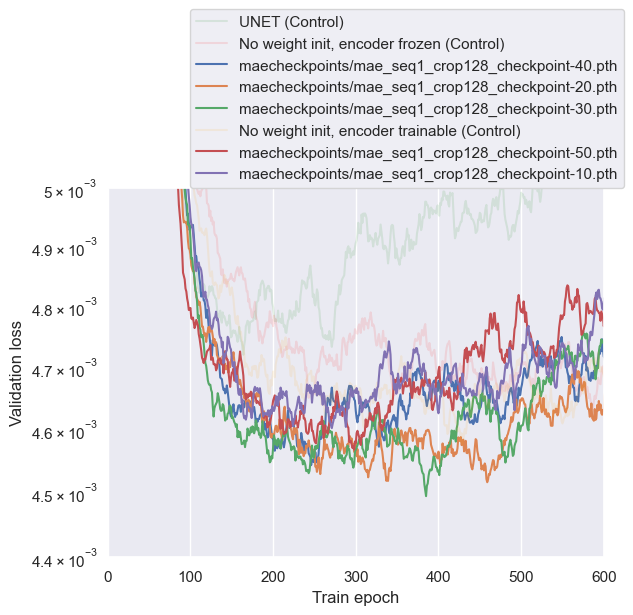

In [30]:
colors = iter(["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"])
for run_hash in small_runs:
    subset = data[data["run.hash"] == run_hash]
    
    sorted_val_loss = subset[subset["metric.name"] == "val_loss"].sort_values("step")["value"]
    
    if "UNETR" == runs_info[run_hash]["model_type"]:
        
        if runs_info[run_hash]["load_checkpoint"] is None:
            
            if runs_info[run_hash]["freeze_encoder"]:
                label = "No weight init, encoder frozen (Control)"
                alpha = 0.1
                col = "red"
                linestyle = "solid"
            else:
                label = "No weight init, encoder trainable (Control)"
                alpha = 0.1
                col = "orange"
                linestyle = "solid"
            
        else:
            label = runs_info[run_hash]["load_checkpoint"]
            alpha = 1
            col = next(colors)
            linestyle = "solid"
    else:
        label = "UNET (Control)"
        alpha = 0.1
        col = "green"
        linestyle = "solid"
    
    plt.plot(smooth(sorted_val_loss, 0.95), label=label, c=col, alpha=alpha, linestyle=linestyle)

plt.yscale("log")
plt.ylim(4.4e-3, 5e-3)
plt.xlim(0, 600)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

plt.xlabel("Train epoch")
plt.ylabel("Validation loss")

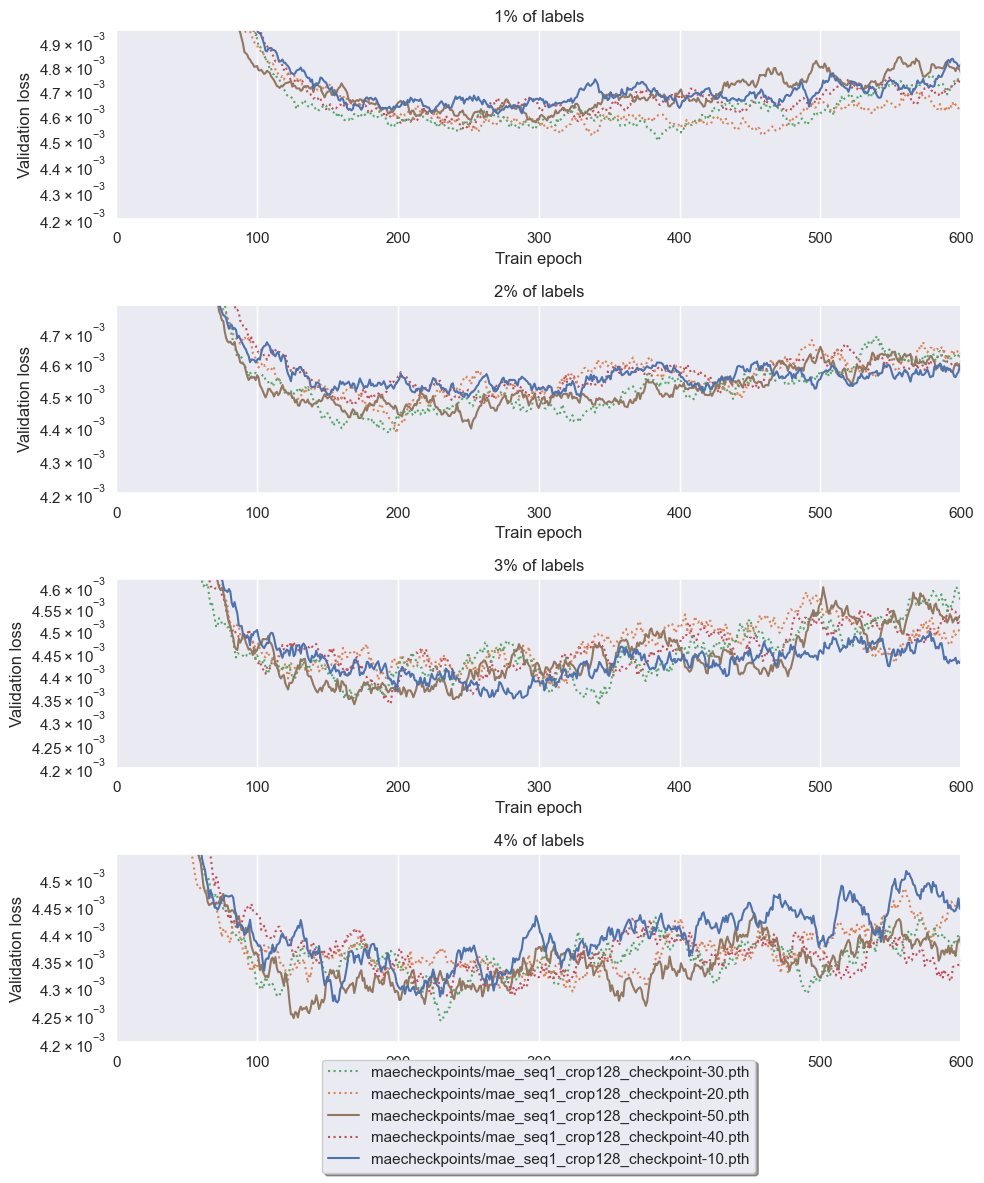

In [63]:
fig, ax = plt.subplots(4,1, figsize=(10,12))

titles = ["1% of labels", "2% of labels", "3% of labels", "4% of labels"]
for idx, runz in enumerate((small_runs, point2runs, point5runs, big_runs)):

    for run_hash in runz:
        subset = data[data["run.hash"] == run_hash]

        sorted_val_loss = subset[subset["metric.name"] == "val_loss"].sort_values("step")["value"]

        if "UNETR" == runs_info[run_hash]["model_type"]:

            if runs_info[run_hash]["load_checkpoint"] is not None:

                label = runs_info[run_hash]["load_checkpoint"]
                alpha = 1
                linestyle = "solid" if (
                    (runs_info[run_hash]["load_checkpoint"] == "maecheckpoints/mae_seq1_crop128_checkpoint-50.pth")
                    or
                    (runs_info[run_hash]["load_checkpoint"] == "maecheckpoints/mae_seq1_crop128_checkpoint-10.pth")
                ) else "dotted"
                
                col = color_mapping[runs_info[run_hash]["load_checkpoint"]]

                ax.flat[idx].plot(smooth(sorted_val_loss, 0.95), label=label, c=col, alpha=alpha, linestyle=linestyle)

    ax.flat[idx].set_title(titles[idx])
    ax.flat[idx].set_yscale("log")
    ax.flat[idx].set_ylim(4.2e-3, max(smooth(sorted_val_loss, 0.95)[100:]))
    ax.flat[idx].set_xlim(0, 600)

    ax.flat[idx].set_xlabel("Train epoch")
    ax.flat[idx].set_ylabel("Validation loss")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=1)
plt.tight_layout()

plt.savefig("pretrain_scale_vs_centroid_loss.pdf")